<a href="https://colab.research.google.com/github/AI-Lab-Makerere/CV4Agriculture_Hackathon24/blob/main/tutorial/Cocoa_Object_Detection_with_YOLO8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install requirements
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.5/756.5 kB 6.6 MB/s eta 0:00:00


In [2]:
# Import libraries
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import glob
from PIL import Image
import pandas as pd
import os
import random
import yaml
import numpy as np
import matplotlib.patches as patches
import shutil

This notebook will show how to train a YOLO8 model for object detection. We shall show how to:
1. Create YOLO format labels from the provided [CSV](https://github.com/AI-Lab-Makerere/CV4Agriculture_Hackathon24/blob/main/resources/cocoa_sample/label_map.csv)
2. Create train, validation and test datasets.
3. Train, Evaluate and Test a Baseline Model
4. Create  a submission file.
5. (Optional) - export a mobile optimized model

## Basic exploration

In [3]:
# Get the data
! wget https://storage.googleapis.com/air-lab-hackathon/Cocoa/cocoa_new.zip
! unzip cocoa_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: cocoa_new/valid/img_2510_JPG_jpg.rf.1b26ec4ea50a73ed84473a25058fe168.jpg  
  inflating: cocoa_new/valid/img_2954_JPG_jpg.rf.d86e11a6386434ec4c5e9bdbd0c66ecf.xml  
  inflating: cocoa_new/valid/img_3920_JPG_jpg.rf.7197873115df59abc4f4130485aba87a.jpg  
  inflating: cocoa_new/valid/img_2510_JPG_jpg.rf.1b26ec4ea50a73ed84473a25058fe168.xml  
  inflating: cocoa_new/valid/img_3082_JPG_jpg.rf.22386dfd0e7220f0261af55f754ac632.jpg  
  inflating: cocoa_new/valid/img_2988_JPG_jpg.rf.d5bd9411b7eba4016505af66b56b82f4.jpg  
  inflating: cocoa_new/valid/img_255_JPG_jpg.rf.3443a4428310daa987a86fdab5ca5e9a.xml  
  inflating: cocoa_new/valid/img_4084_JPG_jpg.rf.159bae477531188c72b3d3a96f66645c.jpg  
  inflating: cocoa_new/valid/img_885_JPG_jpg.rf.5cd9269fad3cbbc6fa995e0ee41b20a1.xml  
  inflating: cocoa_new/valid/img_885_JPG_jpg.rf.5cd9269fad3cbbc6fa995e0ee41b20a1.jpg  
  inflating: cocoa_new/valid/img_2988_JPG_jpg.rf.d5bd9411b7eba4016505af6

In [4]:
import pathlib
data_dir = 'cocoa_new/train/'
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*.jpg')))
print(f'Found {image_count} images')

Found 2274 images


Lets look at some of the images

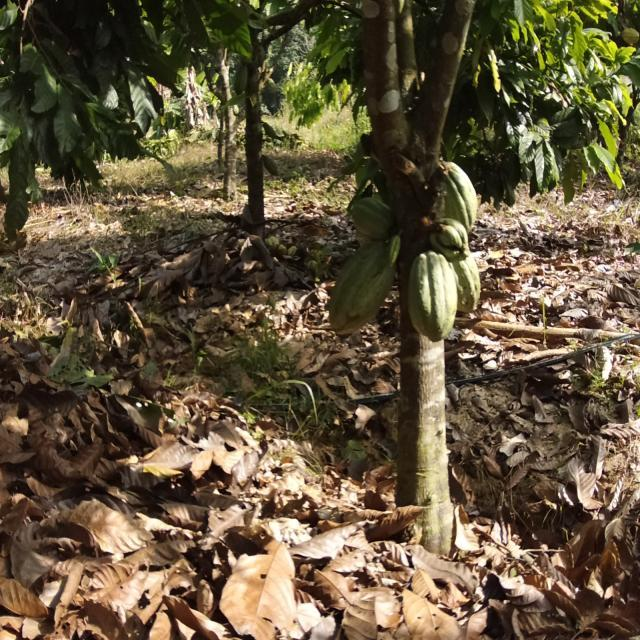

In [5]:
image_list = list(data_dir.glob('*.jpg'))
Image.open(str(image_list[0]))

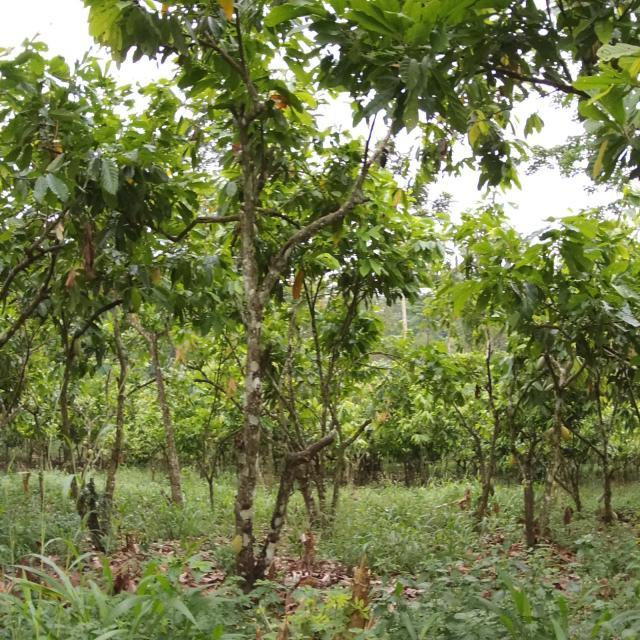

In [6]:
Image.open(str(image_list[12]))

Lets visualize some of the data with the annotations. Ton do this, we shall load the bounding box coordinates from the label_map csv file and then draw them on the image.
lets define some helper functions.

In [7]:
# Load csv file
label_data = pd.read_csv('cocoa_new/train/label_map.csv')
label_data.head()

,Image id,Actual Label,xmin,ymin,xmax,ymax,xmin_norm,xmax_norm,ymin_norm,ymax_norm
0,img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...,Spoit,351,240,380,285,0.548438,0.593750,0.375000,0.593750
1,img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...,Spoit,295,370,337,408,0.460938,0.526563,0.578125,0.526563
2,img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...,Spoit,517,436,535,465,0.807813,0.835938,0.681250,0.835938
3,img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...,Spoit,271,333,297,375,0.423438,0.464062,0.520312,0.464062
4,img_3256_JPG_jpg.rf.1899430ea344d59c764337efc8...,Spoit,291,184,319,220,0.454688,0.498437,0.287500,0.498437


In [8]:
# May need to check data types incase conversions need to be made
label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12265 entries, 0 to 12264
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Image id      12265 non-null  object 
 1   Actual Label  12265 non-null  object 
 2   xmin          12265 non-null  int64  
 3   ymin          12265 non-null  int64  
 4   xmax          12265 non-null  int64  
 5   ymax          12265 non-null  int64  
 6   xmin_norm     12265 non-null  float64
 7   xmax_norm     12265 non-null  float64
 8   ymin_norm     12265 non-null  float64
 9   ymax_norm     12265 non-null  float64
dtypes: float64(4), int64(4), object(2)
memory usage: 958.3+ KB


In [9]:
label_data.columns

Index(['Image id', 'Actual Label', 'xmin', 'ymin', 'xmax', 'ymax', 'xmin_norm',
       'xmax_norm', 'ymin_norm', 'ymax_norm'],
      dtype='object')

In [10]:
def extract_bounding_boxes(df, img_id):
  return df[df['Image id']==img_id][['xmin', 'ymin', 'xmax', 'ymax', 'Actual Label']].values

In [11]:
def extract_bounding_boxes_norm(data_f, img_name):
  return data_f[data_f['Image id']==img_name][['xmin_norm', 'ymin_norm', 'xmax_norm', 'ymax_norm', 'Actual Label']].values

In [12]:
def plot_image_with_bbox(img_path, bboxes):
    # Laod image
    img_arr = Image.open(img_path)

    fig, ax = plt.subplots(1)

    ax.imshow(img_arr)

    for bbox in bboxes:
        x, y, x1, y1, img_lbl = bbox
        # print(img_lbl)
        w = x1-x
        h = y1-y
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.text(x, y,img_lbl, color='b')
        ax.add_patch(rect)

    plt.axis('off')  # Turn off axis
    plt.show()

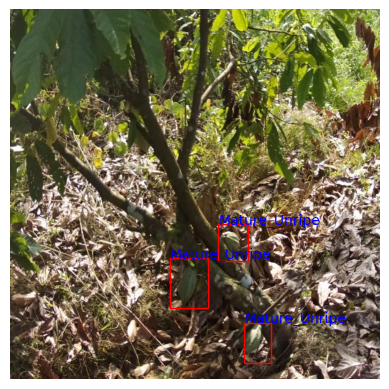

In [13]:
# Select a random sample
sample_image = random.choice(image_list)
sample_bboxes = extract_bounding_boxes(label_data, os.path.basename(sample_image))
plot_image_with_bbox(sample_image, sample_bboxes)

To train a YOLO8 model with ultralytics, we need to convert the dataset into the appropriate format. For this we shall:
1. Create YOLO format annotations from the labeled data. The yolo format is:   
 `class_id x_min y_min x_center ycenter`
2. Organize the directories for the dataset. We shall use:  
  - yolo-data  
    - train
      - images
      - labels
    - val
      - images
      - labels
    - test
      - images
      - labels


3. Create a YAML configuration file with the dataset directories documented.

In [14]:
# Create save directories
for d in ['base', 'train', 'val', 'test']:
  os.makedirs(f'yolo-data/{d}/images', exist_ok=True)
  os.makedirs(f'yolo-data/{d}/labels', exist_ok=True)

In [15]:
# Create label mapping to class names
labels = label_data['Actual Label'].unique()
print(labels)


# Create a label map
cocoa_label_map = {val:idx[0] for  idx, val in np.ndenumerate(labels)}

cocoa_label_map

['Spoit' 'Immature' 'Mature_Unripe' 'Ripped']


{'Spoit': 0, 'Immature': 1, 'Mature_Unripe': 2, 'Ripped': 3}

In [16]:
def generate_yolo_label(df, img_id, save_dir = 'yolo-data/base/labels/'):
  ext_boxes = extract_bounding_boxes_norm(df, img_id)
  img_width, img_height = (640,640)
  with open(save_dir+img_id[:-3]+'txt', 'w') as l_file:
    for b in ext_boxes:
      x1, y1, x2, y2, img_label =  b
      xc = x1+ (x2-x1)/2
      yc  = y1+ (y2-y1)/2
      l_file.write(f'{cocoa_label_map[img_label]} {x1:.6f} {y1:.6f} {xc:.6f} {yc:.6f}\n')


In [17]:
# Test the function
generate_yolo_label(label_data, os.path.basename(sample_image))

# This should create a txt yolo format label file in yolo-data/base/labels

In [18]:
# Loop through label_data and genrate labels for all unique image ids
for i in image_list:
  generate_yolo_label(label_data, os.path.basename(i))

#### Create train test and validation datasets.

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Get all labels
base_labels = glob.glob('yolo-data/base/labels/*.txt')
print(f'Found {len(base_labels)} files.')


train, temp = train_test_split(base_labels, test_size=0.3, random_state=3873)
val, test = train_test_split(temp, test_size=0.5, random_state=928)


print(f'Train has {len(train)} samples')
print(f'Val has {len(val)} samples')
print(f'Test has {len(test)} samples')

Found 2274 files.
Train has 1591 samples
Val has 341 samples
Test has 342 samples


In [21]:
# Copy files to respective folders
for f in train:
  i_name = os.path.basename(f)[:-3]+'jpg'
  shutil.copyfile(f, 'yolo-data/train/labels/'+os.path.basename(f))
  shutil.copyfile('cocoa_new/train/'+i_name, 'yolo-data/train/images/'+i_name)

for f in test:
  i_name = os.path.basename(f)[:-3]+'jpg'
  shutil.copyfile(f, 'yolo-data/test/labels/'+os.path.basename(f))
  shutil.copyfile('cocoa_new/train/'+i_name, 'yolo-data/test/images/'+i_name)

for f in val:
  i_name = os.path.basename(f)[:-3]+'jpg'
  shutil.copyfile(f, 'yolo-data/val/labels/'+os.path.basename(f))
  shutil.copyfile('cocoa_new/train/'+i_name, 'yolo-data/val/images/'+i_name)

### Create a YAML data configuration file for training

In [22]:
yaml_dict = {
    'path': '/content/yolo-data',
    'train': 'train/images',
    'val': 'val/images',
    'names': {idx[0]: val for  idx, val in np.ndenumerate(labels)}

}

with open('data_config.yaml', 'w+') as yml_file:
    yaml.dump(yaml_dict, yml_file)

## Model training


You can consider logging your runs to a service like [WandB](https://wandb.ai/site)

In [23]:
# set some options
# Visit https://docs.ultralytics.com/modes/train/#train-settings to seee complete settings

batch = 4
patience = 10
epochs = 5
optimizer = 'auto'
data_config = '/content/data_config.yaml'
project = 'cocoa-training' # folder where train runs will be stored
name = 'exp_v1.1'  # custom name for specific run folder, may need to make this dynamic

In [24]:
# Load model
# Visit https://docs.ultralytics.com/ for more details about the YOLO model.
model_version = 'yolov8s.pt' # can pick from yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
model = YOLO(model_version)

100%|██████████| 21.5M/21.5M [00:00<00:00, 50.9MB/s]


**Check model benchmarks [here](https://docs.ultralytics.com/tasks/segment/#models)**

In [25]:
# Initialize wandB (optional) but recommended
# !wandb init

In [26]:
# Train the model
results = model.train(data=data_config, epochs=epochs, imgsz=640, project=project, patience=patience, name=name,
                      batch=batch, optimizer=optimizer)

Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data_config.yaml, epochs=5, time=None, patience=10, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=cocoa-training, name=exp_v1.1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 4.82MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 23.6MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo-data/train/labels... 1591 images, 7 backgrounds, 0 corrupt: 100%|██████████| 1591/1591 [00:00<00:00, 2063.17it/s]

train: New cache created: /content/yolo-data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/yolo-data/val/labels... 341 images, 3 backgrounds, 0 corrupt: 100%|██████████| 341/341 [00:00<00:00, 1673.88it/s]

val: New cache created: /content/yolo-data/val/labels.cache


Plotting labels to cocoa-training/exp_v1.1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to cocoa-training/exp_v1.1
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.47G      2.116      2.942      2.413         21        640: 100%|██████████| 398/398 [01:14<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  7.09it/s]

                   all        341       1814      0.416      0.194      0.123     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.41G      1.793      2.702      2.215         33        640: 100%|██████████| 398/398 [01:19<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.21it/s]


                   all        341       1814      0.237      0.258       0.19     0.0725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.41G      1.691      2.642      2.173         14        640: 100%|██████████| 398/398 [01:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00,  9.97it/s]


                   all        341       1814      0.186      0.337      0.211     0.0932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       1.4G      1.617      2.569      2.107         52        640: 100%|██████████| 398/398 [01:13<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:06<00:00,  6.70it/s]


                   all        341       1814      0.217        0.3      0.215      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.41G      1.522      2.455      2.031         49        640: 100%|██████████| 398/398 [01:05<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:04<00:00, 10.03it/s]

                   all        341       1814      0.332      0.391      0.296      0.147



5 epochs completed in 0.110 hours.
Optimizer stripped from cocoa-training/exp_v1.1/weights/last.pt, 22.5MB
Optimizer stripped from cocoa-training/exp_v1.1/weights/best.pt, 22.5MB

Validating cocoa-training/exp_v1.1/weights/best.pt...
Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:09<00:00,  4.52it/s]


                   all        341       1814      0.331      0.391      0.296      0.147
                 Spoit        341        362      0.446      0.355      0.379      0.202
              Immature        341        549      0.332      0.315      0.243      0.117
         Mature_Unripe        341        862      0.339      0.502      0.344      0.169
                Ripped        341         41      0.209       0.39      0.217     0.0979
Speed: 1.0ms preprocess, 8.2ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to cocoa-training/exp_v1.1


In [27]:
# Evaluate the model
metrics = model.val()

Ultralytics YOLOv8.2.11 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/yolo-data/val/labels.cache... 341 images, 3 backgrounds, 0 corrupt: 100%|██████████| 341/341 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:07<00:00, 11.24it/s]


                   all        341       1814      0.331      0.391      0.295      0.147
                 Spoit        341        362      0.444      0.356      0.376      0.202
              Immature        341        549      0.333      0.315      0.243      0.117
         Mature_Unripe        341        862      0.339      0.502      0.344       0.17
                Ripped        341         41      0.209       0.39      0.217     0.0979
Speed: 0.4ms preprocess, 11.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to cocoa-training/exp_v1.12


You can view the results in the saved directory as shown above.  
In this case, results have been stored to the directory `cocoa-training/exp_v1.1/`

# Make Predictions

In [32]:
# Load test data
test_data = glob.glob('yolo-data/test/images/*.jpg')


results = model.predict(test_data, save=True, show_labels=False, show_conf=False, conf=0.1)


0: 640x640 3 Mature_Unripes, 10.9ms
1: 640x640 5 Spoits, 10.9ms
2: 640x640 4 Mature_Unripes, 10.9ms
3: 640x640 1 Spoit, 4 Mature_Unripes, 10.9ms
4: 640x640 3 Mature_Unripes, 10.9ms
5: 640x640 1 Immature, 10 Mature_Unripes, 10.9ms
6: 640x640 3 Mature_Unripes, 10.9ms
7: 640x640 1 Spoit, 1 Mature_Unripe, 1 Ripped, 10.9ms
8: 640x640 1 Spoit, 10.9ms
9: 640x640 3 Spoits, 1 Mature_Unripe, 10.9ms
10: 640x640 3 Spoits, 10.9ms
11: 640x640 (no detections), 10.9ms
12: 640x640 4 Mature_Unripes, 10.9ms
13: 640x640 1 Spoit, 2 Mature_Unripes, 10.9ms
14: 640x640 9 Mature_Unripes, 10.9ms
15: 640x640 6 Mature_Unripes, 10.9ms
16: 640x640 1 Spoit, 2 Mature_Unripes, 10.9ms
17: 640x640 3 Spoits, 10.9ms
18: 640x640 1 Spoit, 10.9ms
19: 640x640 5 Mature_Unripes, 10.9ms
20: 640x640 3 Mature_Unripes, 10.9ms
21: 640x640 1 Spoit, 2 Mature_Unripes, 10.9ms
22: 640x640 6 Mature_Unripes, 10.9ms
23: 640x640 1 Spoit, 5 Mature_Unripes, 10.9ms
24: 640x640 1 Spoit, 3 Mature_Unripes, 10.9ms
25: 640x640 1 Spoit, 8 Mature_Unr

You can find results in the specified folder under the save dir.  
Let's explore what is in our predictions.

In [29]:
print(len(results))

342


The results contain predictions for each input image.  
Lets look at one.

In [33]:
results[7]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Spoit', 1: 'Immature', 2: 'Mature_Unripe', 3: 'Ripped'}
obb: None
orig_img: array([[[134, 132, 132],
        [122, 120, 120],
        [112, 110, 110],
        ...,
        [ 74, 148, 142],
        [ 98, 145, 137],
        [ 96, 131, 121]],

       [[109, 107, 107],
        [111, 109, 109],
        [111, 109, 109],
        ...,
        [ 73, 150, 143],
        [ 93, 144, 136],
        [ 94, 131, 121]],

       [[103, 101, 101],
        [108, 106, 106],
        [111, 109, 109],
        ...,
        [ 61, 143, 138],
        [ 92, 147, 138],
        [ 94, 136, 125]],

       ...,

       [[ 33,  44,  52],
        [ 57,  69,  75],
        [121, 133, 139],
        ...,
        [132, 164, 187],
        [ 99, 131, 160],
        [128, 159, 190]],

       [[ 37,  49,  55],
        [ 42,  54,  60],
        [ 87,  99, 105],
        ...,
        [131, 16

This returns a dictionary of many values.   
We are mainly interested in the boxes data.

In [34]:
# Get boxes from predictions
results[7].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 3., 2.], device='cuda:0')
conf: tensor([0.1096, 0.1094, 0.1001], device='cuda:0')
data: tensor([[2.4780e+02, 0.0000e+00, 5.7381e+02, 3.1535e+02, 1.0962e-01, 0.0000e+00],
        [2.8275e+02, 3.1447e+02, 5.2649e+02, 5.8379e+02, 1.0945e-01, 3.0000e+00],
        [2.6078e+02, 0.0000e+00, 5.8508e+02, 3.0334e+02, 1.0011e-01, 2.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([3, 6])
xywh: tensor([[410.8050, 157.6736, 326.0162, 315.3471],
        [404.6182, 449.1300, 243.7448, 269.3107],
        [422.9326, 151.6714, 324.2981, 303.3428]], device='cuda:0')
xywhn: tensor([[0.6419, 0.2464, 0.5094, 0.4927],
        [0.6322, 0.7018, 0.3809, 0.4208],
        [0.6608, 0.2370, 0.5067, 0.4740]], device='cuda:0')
xyxy: tensor([[247.7969,   0.0000, 573.8131, 315.3471],
        [282.7458, 314.4746, 526.4906, 583.7853],
        [260.7836,   0.0000, 585.0817, 303.3428]], device='cuda:0')


This also returns a dictionary of many values. The values of interest are:  
1. **xywh** - This returns the bounding box coordinates in an array representing `[x_min, y_min, bounding_box_width , bounding_box_height]`
2. **xyxy** - This returns the bounding box coordinates in an array representing `[x_min, y_min, x_max , y_max]`
3. The values **xywhn** and **xyxyn** are the same as above only that they are normalized. In this case, the bounding box coordinates in `xyxyn` are what we need to prepare our submission file.
4. The **conf** returns the confidences of the bounding boxes.
5. The **cls** value returns the classes predicted for each bounding box


In [40]:
# We shall extract the normalized coordinates as that is what we are interested in
# We shall also get the predicted classes. For this we shall use the label map to get the actual class later
# Finally we shall get the confidence values of the predictions.

filenames = [os.path.basename(r.path) for idx, r in enumerate(results) for b in r.boxes.xyxyn.cpu().numpy()]
pred_boxes = np.concatenate([r.boxes.xyxyn.cpu().numpy() for r in results])
pred_classes = np.concatenate([r.boxes.cls.cpu().numpy() for r in results])
pred_confidence = np.concatenate([r.boxes.conf.cpu().numpy() for r in results])
# for r in results:
#   pred_boxes = np.append(r.boxes.xyxyn.cpu().numpy())
# results[7].boxes.xyxyn.cpu().numpy()

### Creating a Submission file
The CSv must have 7 columns:  
`filename, Class, Confidence, ymin, xmin, ymax, xmax`.   

Each row represents a detected bounding box in an image.  
 - Class: The cocoa class (e.g. cocoa mature unripe, cocoa immature, cocoa ripped or cocoa spoilt.)
 - Confidence: Confidence score of the detection (between 0 and 1)
 - ymin, xmin, ymax, xmax: Normalized bounding box coordinates (between 0 and 1).

  - ymin: Top-left y-coordinate (0 at the top of the image)
  - xmin: Top-left x-coordinate (0 at the left of the image)
  - ymax: Bottom-right y-coordinate (1 at the bottom of the image)
  - xmax: Bottom-right x-coordinate (1 at the right of the image)


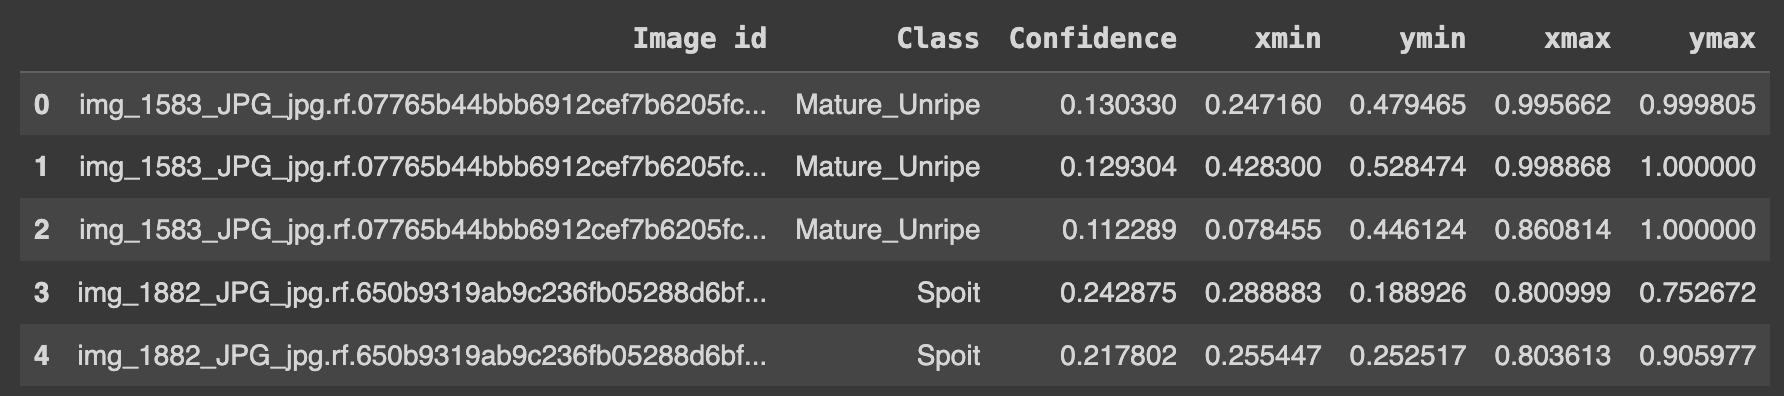

In [44]:
# Lets reverse the labelmap
cocoa_label_map_rev = {cocoa_label_map[key]:key for key in cocoa_label_map}
cocoa_label_map_rev

{0: 'Spoit', 1: 'Immature', 2: 'Mature_Unripe', 3: 'Ripped'}

In [52]:
# Get Actual Labels by from predicted classes
pred_labels = list(map(lambda x : cocoa_label_map_rev[x], list(pred_classes.astype(int))))

In [61]:
submission_df = pd.DataFrame(
    {
        'Image id': filenames,
        'Class': pred_labels,
        'Confidence': pred_confidence,
        'xmin': pred_boxes[:, 0],
        'ymin': pred_boxes[:, 1],
        'xmax': pred_boxes[:, 2],
        'ymax': pred_boxes[:, 3],

    }
)

submission_df.head()

,Image id,Class,Confidence,xmin,ymin,xmax,ymax
0,img_1583_JPG_jpg.rf.07765b44bbb6912cef7b6205fc...,Mature_Unripe,0.130330,0.247160,0.479465,0.995662,0.999805
1,img_1583_JPG_jpg.rf.07765b44bbb6912cef7b6205fc...,Mature_Unripe,0.129304,0.428300,0.528474,0.998868,1.000000
2,img_1583_JPG_jpg.rf.07765b44bbb6912cef7b6205fc...,Mature_Unripe,0.112289,0.078455,0.446124,0.860814,1.000000
3,img_1882_JPG_jpg.rf.650b9319ab9c236fb05288d6bf...,Spoit,0.242875,0.288883,0.188926,0.800999,0.752672
4,img_1882_JPG_jpg.rf.650b9319ab9c236fb05288d6bf...,Spoit,0.217802,0.255447,0.252517,0.803613,0.905977


In [62]:
# Save to a CSV
submission_df.to_csv('team_name.csv', index=False)

Ensure that your CSV is named with your team name. For example if the team name is Expendables, the CSV must be saves as `Expendables.csv`

## Optional- Export to tflite model for mobile inference

In [ ]:
# Export model
# form = "tflite"
# model.export(format=form)